EP:0, Avg_Score:-1243.1, MaxQ_Action_Count:18, Epsilon:0.90000
EP:1, Avg_Score:-1323.8, MaxQ_Action_Count:38, Epsilon:0.81000
EP:2, Avg_Score:-1296.2, MaxQ_Action_Count:55, Epsilon:0.72900
EP:3, Avg_Score:-1287.9, MaxQ_Action_Count:74, Epsilon:0.65610
EP:4, Avg_Score:-1274.3, MaxQ_Action_Count:71, Epsilon:0.59049
EP:5, Avg_Score:-984.2, MaxQ_Action_Count:96, Epsilon:0.53144
EP:6, Avg_Score:-858.3, MaxQ_Action_Count:97, Epsilon:0.47830
EP:7, Avg_Score:-497.1, MaxQ_Action_Count:107, Epsilon:0.43047
EP:8, Avg_Score:-379.3, MaxQ_Action_Count:124, Epsilon:0.38742
EP:9, Avg_Score:-374.7, MaxQ_Action_Count:129, Epsilon:0.34868
EP:10, Avg_Score:-640.3, MaxQ_Action_Count:144, Epsilon:0.31381
EP:11, Avg_Score:-262.2, MaxQ_Action_Count:130, Epsilon:0.28243
EP:12, Avg_Score:-369.9, MaxQ_Action_Count:144, Epsilon:0.25419
EP:13, Avg_Score:-326.0, MaxQ_Action_Count:161, Epsilon:0.22877
EP:14, Avg_Score:-519.0, MaxQ_Action_Count:156, Epsilon:0.20589
EP:15, Avg_Score:-124.8, MaxQ_Action_Count:165, Epsi

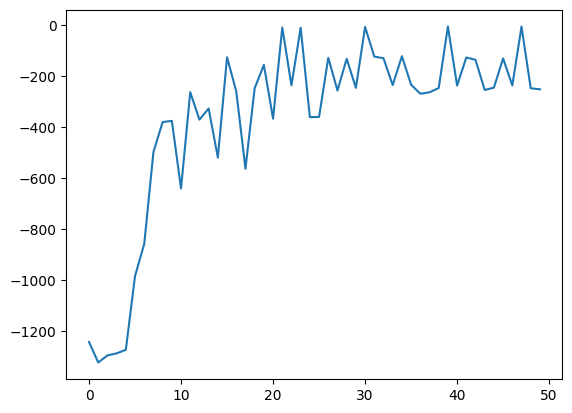

In [36]:
import os
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

def transform_action_values(n_actions, min_action=-2.0, max_action=2.0):
    # Linearly spaced values between -1 and 1
    linear_actions = np.linspace(-1, 1, n_actions)

    # Apply a quadratic transformation
    non_linear_actions = np.sign(linear_actions) * (linear_actions ** 2)

    # Scale to the action range of the environment
    scaled_actions = min_action + (non_linear_actions + 1) * (max_action - min_action) / 2
    return scaled_actions

# ReplayBuffer from https://github.com/seungeunrho/minimalRL
class ReplayBuffer:
    def __init__(self, buffer_limit):
        self.buffer = deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask = 0.0 if done else 1.0
            done_mask_lst.append([done_mask])

        s_batch = torch.tensor(s_lst, dtype=torch.float)
        a_batch = torch.tensor(a_lst, dtype=torch.float)
        r_batch = torch.tensor(r_lst, dtype=torch.float)
        s_prime_batch = torch.tensor(s_prime_lst, dtype=torch.float)
        done_batch = torch.tensor(done_mask_lst, dtype=torch.float)

        # r_batch = (r_batch - r_batch.mean()) / (r_batch.std() + 1e-7)

        return s_batch, a_batch, r_batch, s_prime_batch, done_batch

    def size(self):
        return len(self.buffer)


class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, q_lr):
        super(QNetwork, self).__init__()

        self.fc_1 = nn.Linear(state_dim, 64)
        self.fc_2 = nn.Linear(64, 32)
        self.fc_out = nn.Linear(32, action_dim)

        self.lr = q_lr

        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, x):
        q = F.leaky_relu(self.fc_1(x))
        q = F.leaky_relu(self.fc_2(q))
        q = self.fc_out(q)
        return q


class DQNAgent:
    def __init__(self):
        self.state_dim     = 3
        self.action_dim    = 11
        self.lr            = 0.01
        self.gamma         = 0.995
        self.tau           = 0.01
        self.epsilon       = 0.9
        self.epsilon_decay = 0.9
        self.epsilon_min   = 0.001
        self.buffer_size   = 1000000
        self.batch_size    = 256
        self.memory        = ReplayBuffer(self.buffer_size)
        self.action_list = transform_action_values(self.action_dim, min_action=-2.0, max_action=2.0)

        self.Q        = QNetwork(self.state_dim, self.action_dim, self.lr)
        self.Q_target = QNetwork(self.state_dim, self.action_dim, self.lr)
        self.Q_target.load_state_dict(self.Q.state_dict())

    def choose_action(self, state):
        random_number = np.random.rand()
        maxQ_action_count = 0
        if self.epsilon < random_number:
            with torch.no_grad():
                action = float(torch.argmax(self.Q(state)).numpy())
                maxQ_action_count = 1
        else:
            action = float(np.random.choice([n for n in range(self.action_dim)]))
        real_action = self.action_list[int(action)]

        return action, real_action, maxQ_action_count

    def calc_target(self, mini_batch):
        s, a, r, s_prime, done = mini_batch
        with torch.no_grad():
            q_target = self.Q_target(s_prime).max(1)[0].unsqueeze(1)
            target = r + self.gamma * done * q_target
        return target

    def train_agent(self):
        mini_batch = self.memory.sample(self.batch_size)
        s_batch, a_batch, r_batch, s_prime_batch, done_batch = mini_batch
        a_batch = a_batch.type(torch.int64)

        td_target = self.calc_target(mini_batch)

        #### Q train ####
        Q_a = self.Q(s_batch).gather(1, a_batch)
        q_loss = F.smooth_l1_loss(Q_a, td_target)
        self.Q.optimizer.zero_grad()
        q_loss.mean().backward()
        self.Q.optimizer.step()
        #### Q train ####

        #### Q soft-update ####
        for param_target, param in zip(self.Q_target.parameters(), self.Q.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)


if __name__ == '__main__':
    ###### logging ######

    agent = DQNAgent()

    env = gym.make('Pendulum-v1')

    EPISODE = 50
    print_once = True
    score_list = []

    # Fill up the replay buffer with random actions
    while agent.memory.size() < 4 * agent.batch_size:
        state, _info = env.reset()
        done = False

        while not done:
            action, real_action, _ = agent.choose_action(torch.FloatTensor(state))
            state_prime, reward, terminated, truncated, _ = env.step([real_action])

            if terminated or truncated:
                done = True

            agent.memory.put((state, action, reward, state_prime, terminated))
            state = state_prime

    for EP in range(EPISODE):
        state, _info = env.reset()
        score, done = 0.0, False
        maxQ_action_count = 0

        while not done:
            action, real_action, count = agent.choose_action(torch.FloatTensor(state))

            state_prime, reward, terminated, truncated, _ = env.step([real_action])

            agent.memory.put((state, action, reward, state_prime, terminated))

            agent.train_agent()

            if terminated or truncated:
                done = True

            score += reward
            maxQ_action_count += count

            state = state_prime

        print("EP:{}, Avg_Score:{:.1f}, MaxQ_Action_Count:{}, Epsilon:{:.5f}".format(EP, score, maxQ_action_count, agent.epsilon))
        score_list.append(score)
        agent.epsilon = max(agent.epsilon_min, agent.epsilon*agent.epsilon_decay)

    # score = [float(s) for s in data]

    plt.plot(score_list)
    plt.show()

In [37]:
def run_trials(agent, num_trials=10):
    env = gym.make('Pendulum-v1', render_mode='human')
    for trial in range(num_trials):
        state, _info = env.reset()
        done = False
        while not done:
            action, real_action, count = agent.choose_action(torch.FloatTensor(state))
            state_prime, reward, terminated, truncated, _ = env.step([real_action])

            state = state_prime
        print(f"Trial {trial + 1} completed")
    env.close()

In [38]:
run_trials(agent)


KeyboardInterrupt: 